In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Importing data

In [3]:
train_file_path = 'lab2_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

test_file_path = 'lab2_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',')


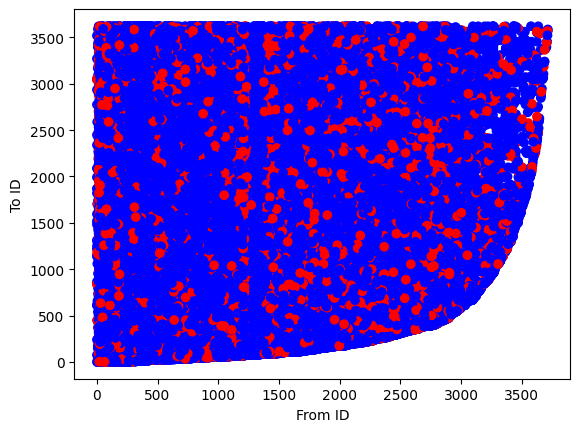

In [10]:
is_like = train_data['is_like'].to_numpy()

colors = ['red' if v else 'blue' for v in is_like]

plt.scatter(x=train_data['user_from_id'], y=train_data['user_to_id'], c=colors)

plt.xlabel('From ID')
plt.ylabel('To ID')

# Show the plot
plt.show()

In [4]:
train_data

,user_from_id,user_to_id,is_like,is_match
0,1136,3141,False,False
1,2424,3174,False,False
2,1300,3590,False,False
3,800,2736,False,False
4,883,437,False,False
...,...,...,...,...
76387,2376,3057,False,False
76388,1163,933,False,False
76389,2770,3324,False,False
76390,879,785,False,False


In [5]:
test_data

,user_from_id,user_to_id,is_like,is_match
0,2644,2595,?,?
1,567,2412,?,?
2,2732,3187,?,?
3,783,854,?,?
4,1104,2723,?,?
...,...,...,...,...
16198,2197,1449,?,?
16199,2507,316,?,?
16200,511,889,?,?
16201,2148,2947,?,?


### Non-negative matrix factorization

In [6]:
import numpy as np
import pandas as pd


def nmf(X: pd.DataFrame, n_components: int, max_iter: int=1000, tol: float=1e-3):
  """
  Decomposes the original sparse matrix X into two matrices W and H. 
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  curr_iter = 0
  prev_error = np.linalg.norm(X - W @ H) ** 2
  
  # START ANSWER
  while curr_iter < max_iter:    
    top = ((W.T) @ X)
    bottom = ((W.T) @ W @ H)
    H = H * top / (bottom + 1e-9)

    top = (X @ (H.T))
    bottom = (W @ H @ (H.T))

    W = W * top / (bottom + 1e-9)
    
    reconstruction_error = np.linalg.norm(X - W @ H) ** 2
    
    if prev_error - reconstruction_error < tol:
      break
    
    curr_iter += 1
  # END ANSWER

  return W, H

### Minhashing

In [7]:
import numpy as np
import sys
from library import HashFunction


def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    for ix,r in enumerate(sorted_space):
        for c in range(result.shape[1]):
            if r in ids[c]:
                for i, hf in enumerate(hashes):
                    result[i][c] = min(result[i][c], hf.hashf(ix, len(sorted_space)))

    return result

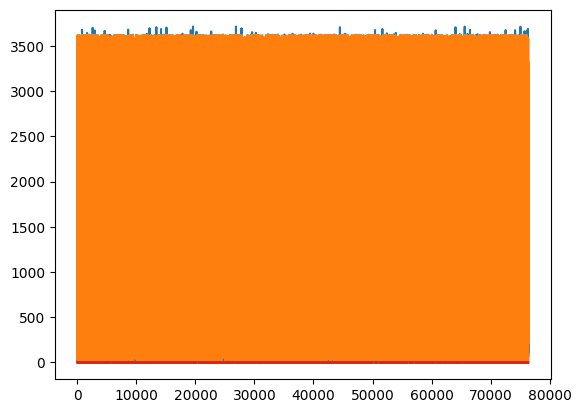

In [8]:

plt.plot()
